In [ ]:
import networkx as nx
import osmnx as ox
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt

ox.__version__

'2.0.1'

In [2]:
ville = "Vallorbe, District du Jura-Nord vaudois, Vaud, 1337, Suisse"

print("Chargement des graphes...")
G_drive_proj = ox.graph.graph_from_place(ville, network_type="drive")
G_walk_proj = ox.graph.graph_from_place(ville, network_type="walk")

# print("Projection des graphes...")
# G_drive_proj = ox.project_graph(G_drive, to_crs="EPSG:2056")
# G_walk_proj = ox.project_graph(G_walk, to_crs="EPSG:2056")

print("Calcul des vitesses pour drive...")
G_drive_proj = ox.routing.add_edge_speeds(G_drive_proj)
G_drive_proj = ox.routing.add_edge_travel_times(G_drive_proj)

print("Application des vitesses personnalisées pour walk...")
G_walk_proj = ox.routing.add_edge_speeds(G_walk_proj)
G_walk_proj = ox.routing.add_edge_travel_times(G_walk_proj)
for u, v, k, data in G_walk_proj.edges(keys=True, data=True):
    data["speed_kph"] = 30  # Vitesse par défaut pour les pompiers sur toutes routes
G_walk_proj = ox.routing.add_edge_travel_times(G_walk_proj)

print("Fusion des graphes...")
G_combined = nx.compose(G_drive_proj, G_walk_proj)

Chargement des graphes...
Calcul des vitesses pour drive...
Application des vitesses personnalisées pour walk...
Fusion des graphes...


In [ ]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G_combined, nodes=True, edges=True)

osmid      highway   lanes  \
u           v           key                                                
31298507    1092005864  0                  93933971      primary       1   
            3192346600  0    [93933920, 1245799091]      primary  [2, 3]   
            3827706362  0                  93933971      primary       1   
            8779512575  0                 318565457      primary       1   
            1092006026  0                1245799091      primary       2   
...                                             ...          ...     ...   
12607339090 12607339091 0                1361739695      service     NaN   
12607339091 2647312926  0                 130573503  residential     NaN   
            12607339090 0                1361739695      service     NaN   
            2647312918  0                 130573503  residential     NaN   
12607378723 12607378719 0                 297792668      service     NaN   

                                         name  oneway  ref reversed  \
u           v           key                                           
31298507    1092005864  0      Route du Creux    True    9    False   
            3192346600  0      Route du Creux   False    9    False   
            3827706362  0      Route du Creux   False    9    False   
            8779512575  0      Route du Creux   False    9     True   
            1092006026  0      Route du Creux   False    9    False   
...                                       ...     ...  ...      ...   
12607339090 12607339091 0                 NaN   False  NaN     True   
12607339091 2647312926  0    Rue du Mont-d'Or   False  NaN     True   
            12607339090 0                 NaN   False  NaN    False   
            2647312918  0    Rue du Mont-d'Or   False  NaN    False   
12607378723 12607378719 0                 NaN   False  NaN     True   

                                 length  \
u           v           key               
31298507    1092005864  0     93.421226   
            3192346600  0    124.267159   
            3827706362  0     26.148177   
            8779512575  0     19.752162   
            1092006026  0      7.621480   
...                                 ...   
12607339090 12607339091 0     15.261915   
12607339091 2647312926  0      6.000696   
            12607339090 0     15.261915   
            2647312918  0     29.960337   
12607378723 12607378719 0     31.382891   

                                                                      geometry  \
u           v           key                                                      
31298507    1092005864  0    LINESTRING (6.38609 46.7311, 6.38583 46.73124,...   
            3192346600  0    LINESTRING (6.38609 46.7311, 6.38618 46.73106,...   
            3827706362  0       LINESTRING (6.38609 46.7311, 6.38583 46.73124)   
            8779512575  0       LINESTRING (6.38609 46.7311, 6.38585 46.73116)   
            1092006026  0       LINESTRING (6.38609 46.7311, 6.38618 46.73106)   
...                                                                        ...   
12607339090 12607339091 0      LINESTRING (6.38147 46.71413, 6.38137 46.71425)   
12607339091 2647312926  0      LINESTRING (6.38137 46.71425, 6.38144 46.71428)   
            12607339090 0      LINESTRING (6.38137 46.71425, 6.38147 46.71413)   
            2647312918  0    LINESTRING (6.38137 46.71425, 6.38128 46.71422...   
12607378723 12607378719 0    LINESTRING (6.37996 46.71435, 6.37988 46.71444...   

                             speed_kph  travel_time maxspeed tunnel width  \
u           v           key                                                 
31298507    1092005864  0    58.469945     5.751954      NaN    NaN   NaN   
            3192346600  0    60.000000     7.456030       60    NaN   NaN   
            3827706362  0    30.000000     3.137781      NaN    NaN   NaN   
            8779512575  0    30.000000     2.370259      NaN    NaN   NaN   
            1092006026  0    30.000000     0

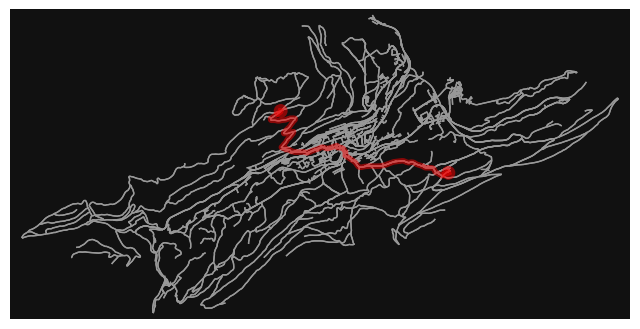

In [ ]:
# # Coordonnées en WGS84
# lon_orig, lat_orig = 6.4031464, 46.7065807
# lon_dest, lat_dest = 6.3643332, 46.7187537

# # # 1. Créer un GeoDataFrame avec les points d'origine et destination
# # gdf_points = gpd.GeoDataFrame(geometry=[
# #     Point(lon_orig, lat_orig),
# #     Point(lon_dest, lat_dest)
# # ], crs="EPSG:4326")

# # # 2. Reprojeter les points en EPSG:2056 pour correspondre au graphe
# # gdf_points_proj = gdf_points.to_crs("EPSG:2056")

# # # 3. Extraire les coordonnées projetées
# # x_orig, y_orig = gdf_points_proj.geometry.iloc[0].x, gdf_points_proj.geometry.iloc[0].y
# # x_dest, y_dest = gdf_points_proj.geometry.iloc[1].x, gdf_points_proj.geometry.iloc[1].y

# # 4. Trouver les nœuds les plus proches
# orig = ox.distance.nearest_nodes(G_combined, X=lon_orig, Y= lat_orig)
# dest = ox.distance.nearest_nodes(G_combined, X=lon_dest, Y= lat_dest)

# # 5. Calculer le chemin le plus rapide (pondéré par le temps de trajet)
# route = ox.routing.shortest_path(G_combined, orig, dest, weight="travel_time")

# fig, ax = ox.plot.plot_graph_route(G_combined, route, node_size=0)

In [ ]:
# total_time_sec = 0
# total_dist_m = 0
# incomplete_edges = 0  # compteur d’arêtes incomplètes

# for u, v in zip(route[:-1], route[1:]):
#     edges = G_combined.get_edge_data(u, v)

#     if not edges:
#         print(f"⚠️ Aucun segment entre {u} → {v}")
#         continue

#     selected_edge = None
#     for edge in edges.values():
#         if "travel_time" in edge and "length" in edge:
#             selected_edge = edge
#             break

#     if selected_edge is None:
#         # Afficher un message d'avertissement
#         print(f"⚠️ Arête incomplète entre {u} → {v}, attributs manquants (travel_time ou length)")
#         selected_edge = list(edges.values())[0]  # on prend quand même la première
#         incomplete_edges += 1

#     total_time_sec += selected_edge.get("travel_time", 0)
#     total_dist_m += selected_edge.get("length", 0)

# # Conversion
# total_time_min = total_time_sec / 60
# total_dist_km = total_dist_m / 1000

# # Résumé final
# print(f"\n🕒 Temps total estimé : {total_time_min:.1f} minutes")
# print(f"📏 Distance totale : {total_dist_km:.2f} km")

# if incomplete_edges > 0:
#     print(f"⚠️ {incomplete_edges} arêtes utilisées n'avaient pas tous les attributs nécessaires.")


🕒 Temps total estimé : 7.7 minutes
📏 Distance totale : 4.76 km


In [ ]:
print("5. Conversion en GeoDataFrames...")
gdf_nodes, gdf_edges = ox.convert.graph_to_gdfs(G_combined, nodes=True, edges=True)
print(f"   ➤ {len(gdf_nodes)} nœuds et {len(gdf_edges)} arêtes extraits.")

nom_fichier = "Vaud"
print("6. Export du graphe en Geopackage...")
ox.io.save_graph_geopackage(G_combined, filepath=nom_fichier + ".gpkg")
print("   ➤ Fichier .gpkg enregistré.")

print("7. Export du graphe en GraphML...")
ox.io.save_graphml(G_combined, filepath=nom_fichier + ".graphml")
print("   ➤ Fichier .graphml enregistré.")

print("✅ Traitement terminé avec succès.")

5. Conversion en GeoDataFrames...
   ➤ 1414 nœuds et 3788 arêtes extraits.
6. Export du graphe en Geopackage...
   ➤ Fichier .gpkg enregistré.
7. Export du graphe en GraphML...
   ➤ Fichier .graphml enregistré.
✅ Traitement terminé avec succès.
